In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

In [43]:
train_data1 = pd.read_csv('train_ver_2.csv')
test_data1 = pd.read_csv('test_ver_2.csv')

bins = [0,40,50,60,70,200]
labels = ['20,30대','40대','50대','60대','70대 이상']

train_data1['Age_group'] = pd.cut(train_data1['Age'], bins = bins, labels = labels)
test_data1['Age_group'] = pd.cut(test_data1['Age'], bins = bins, labels = labels)
    



array([0.56086315, 0.1269445 , 0.11401669, 0.07192039])

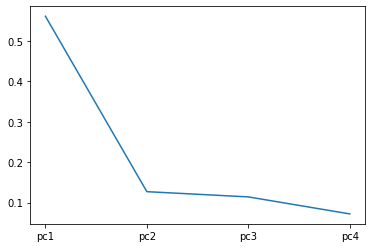

In [44]:
x = train_data1[['MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']]
pca_std_scale = StandardScaler()
pca_data_std = pca_std_scale.fit_transform(x)

pca = PCA(n_components = 4)
pcas = pca.fit_transform(pca_data_std)

plt.plot(['pc1','pc2','pc3','pc4'], pca.explained_variance_ratio_)
pca.explained_variance_ratio_
# 3개 주성분 사용

In [45]:
pca = PCA(n_components = 3)
pcas = pca.fit_transform(pca_data_std)
pcas = pd.DataFrame(pcas, columns = ['pc1','pc2','pc3'])

# 주성분 독립성 확인
pcas.corr(method = 'pearson')

# 주성분 로딩값 확인
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=['pc1','pc2','pc3'],  # so the columns are the principal components
    index=['MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds'],  # and the rows are the original features
)
loadings

pc1       pc2       pc3
MntWines          0.369176  0.638978 -0.438066
MntFruits         0.428870 -0.342421  0.136145
MntMeatProducts   0.434901  0.091608 -0.418714
MntFishProducts   0.443712 -0.270849  0.117970
MntSweetProducts  0.418406 -0.410605 -0.077687
MntGoldProds      0.344524  0.473399  0.770902

In [46]:
train_data1['pc1'] = pcas.pc1
train_data1['pc2'] = pcas.pc2
train_data1['pc3'] = pcas.pc3

# Train 데이터를 Train과 Validation 세트로 나누기
X_train1, X_val1, y_train1, y_val1 = train_test_split(train_data1.drop(columns=['Response']),
                                                  train_data1['Response'],
                                                  test_size=0.2,
                                                  stratify=train_data1['Response'],
                                                  random_state = 31)

# under sampling용 변수 설정
np.random.seed(42)
X_train1['group'] = np.where(y_train1 == 1, 0, np.random.randint(1, 7, size=len(y_train1)))


In [50]:
hyper_param = pd.DataFrame(columns=['C', 'solver', 'penalty', 'max_iter', 'tol'])
target = []
for i in range(1,7):
    train = X_train1[(X_train1['group'].isin([0,i]))]
    y = y_train1[train.index]
    
    categorical_cols = ['Education', 'Marital_Status']
    numeric_cols = [col for col in train.columns if col not in ['Education', 'Marital_Status', 'Response', 'group', 'Age_group','MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']]
    
    # standard scaler
    std_scale = StandardScaler()
    train_data_std = std_scale.fit_transform(train[numeric_cols])
    
    oh_encod = OneHotEncoder(sparse_output=False)
    train_data_enc = oh_encod.fit_transform(train[categorical_cols])
    
    # process dataset 
    processed_data = np.hstack((train_data_std, train_data_enc))

    
    processed_data = np.hstack((train_data_std, train_data_enc))

    def logistic_regression_cv2(C, solver, penalty, max_iter, tol):
        C = 10 ** C  # 로그 스케일 C 변환
        max_iter = int(max_iter)
        tol = 10 ** tol  # 로그 스케일 tol 변환
        penalty_options = ['l1', 'l2', None]  # 'none' 옵션 추가
        solver_options = ['liblinear', 'saga']

        # 범주형 매개변수 매핑
        penalty = penalty_options[int(penalty)]
        solver = solver_options[int(solver)]
        if penalty is None and solver not in ['lbfgs', 'newton-cg', 'sag', 'saga']:
            return 0 # 'None' 규제는 'liblinear'와 호환되지 않음

        # 모델 생성
        model = LogisticRegression(C=C, penalty=penalty, solver=solver, max_iter=max_iter, tol=tol, random_state=42)
    
        #cross_val_score를 사용하여 교차 검증을 수행, scoring을 'f1'으로 설정
        scores2 = cross_val_score(model, processed_data, y, cv=3, scoring='f1')
    
        # 평균 점수 반환
        return scores2.mean()
    
    # 베이지안 최적화의 파라미터 공간 정의
    params = {
        'C': (-6, 6),  # 로그 스케일로 C 파라미터 탐색
        'solver': (0, 1),  # 0 = 'liblinear', 1 = 'saga'
        'penalty': (0, 2),  # 0 = 'l1', 1 = 'l2', 2 = 'none'
        'max_iter': (10, 500),  # 정수 범위
        'tol': (-6, -1)  # 로그 스케일로 tol 파라미터 탐색
    }
    
    # BayesianOptimization 객체 생성
    optimizer2 = BayesianOptimization(
        f=logistic_regression_cv2,  # 최적화할 함수
        pbounds=params,            # 파라미터 범위
        random_state=42,
        verbose=2
    )
    

    # 최적화 수행
    optimizer2.maximize(
        init_points=5,   # 랜덤하게 탐색할 초기 포인트 수
        n_iter=25,       # 베이지안 최적화를 통해 탐색할 포인트 수
    )
    
    # 파라미터 정리
    penalty_options = ['l1', 'l2', None]
    solver_options = ['liblinear', 'saga']
    
    # f1 파라미터
    best_f1_C = 10 ** optimizer2.max['params']['C']
    best_f1_max_iter = int(round(optimizer2.max['params']['max_iter']))  # 반올림 후 정수 변환
    best_f1_penalty_index = int(round(optimizer2.max['params']['penalty']))  # 반올림 후 인덱스 변환
    best_f1_penalty = penalty_options[best_f1_penalty_index]
    best_f1_solver_index = int(round(optimizer2.max['params']['solver']))  # 반올림 후 인덱스 변환
    best_f1_solver = solver_options[best_f1_solver_index]
    best_f1_tol = 10 ** -optimizer2.max['params']['tol']  
    
    best_f1 = {
        'C': best_f1_C,
        'max_iter': best_f1_max_iter,
        'penalty': best_f1_penalty,
        'solver': best_f1_solver,
        'tol': best_f1_tol
    }

    hyper_param = hyper_param.append(optimizer2.max['params'],ignore_index = True)
    target.append(optimizer2.max['target'])


|   iter    |  target   |     C     | max_iter  |  penalty  |  solver   |    tol    |
-------------------------------------------------------------------------------------
| 1         | 0.7641    | -1.506    | 475.9     | 1.464     | 0.5987    | -5.22     |
| 2         | 0.6553    | -4.128    | 38.46     | 1.732     | 0.6011    | -2.46     |
| 3         | 0.6553    | -5.753    | 485.3     | 1.665     | 0.2123    | -5.091    |
| 4         | 0.6618    | -3.799    | 159.1     | 1.05      | 0.4319    | -4.544    |
| 5         | 0.7524    | 1.342     | 78.35     | 0.5843    | 0.3664    | -3.72     |
| 6         | 0.7704    | -1.291    | 476.4     | 1.851     | 0.6605    | -5.956    |
| 7         | 0.7524    | 4.776     | 474.6     | 1.772     | 0.2098    | -5.649    |
| 8         | 0.7551    | 0.4608    | 466.7     | 1.841     | 0.9176    | -5.508    |
| 9         | 0.7524    | 2.578     | 88.51     | 1.011     | 0.7593    | -2.769    |
| 10        | 0.6553    | -5.795    | 85.05     | 1.65

| 27        | 0.796     | 2.555     | 283.3     | 0.2605    | 0.7284    | -1.211    |
| 28        | 0.7912    | 6.0       | 69.24     | 2.0       | 1.0       | -6.0      |
| 29        | 0.771     | 6.0       | 431.6     | 2.0       | 1.0       | -1.0      |
| 30        | 0.6839    | -6.0      | 52.67     | 0.0       | 1.0       | -6.0      |
|   iter    |  target   |     C     | max_iter  |  penalty  |  solver   |    tol    |
-------------------------------------------------------------------------------------
| 1         | 0.7627    | -1.506    | 475.9     | 1.464     | 0.5987    | -5.22     |
| 2         | 0.6646    | -4.128    | 38.46     | 1.732     | 0.6011    | -2.46     |
| 3         | 0.6646    | -5.753    | 485.3     | 1.665     | 0.2123    | -5.091    |
| 4         | 0.6646    | -3.799    | 159.1     | 1.05      | 0.4319    | -4.544    |
| 5         | 0.7668    | 1.342     | 78.35     | 0.5843    | 0.3664    | -3.72     |
| 6         | 0.7122    | -1.355    | 348.6     | 0.51

| 22        | 0.7845    | 0.5148    | 37.01     | 0.0       | 0.0       | -6.0      |
| 23        | 0.7747    | 3.996     | 36.07     | 0.7334    | 0.1278    | -3.601    |
| 24        | 0.7797    | 1.458     | 39.6      | 0.0       | 1.0       | -2.14     |
| 25        | 0.7815    | 3.81      | 40.57     | 2.0       | 1.0       | -6.0      |
| 26        | 0.7576    | -1.199    | 42.79     | 0.4329    | 0.1142    | -5.758    |
| 27        | 0.7747    | 3.864     | 44.93     | 0.0       | 0.0       | -3.085    |
| 28        | 0.7802    | -0.6023   | 45.96     | 1.85      | 0.5738    | -1.412    |
| 29        | 0.7863    | 1.392     | 49.16     | 2.0       | 1.0       | -6.0      |
| 30        | 0.7874    | 2.573     | 52.04     | 0.8433    | 0.392     | -1.258    |
|   iter    |  target   |     C     | max_iter  |  penalty  |  solver   |    tol    |
-------------------------------------------------------------------------------------
| 1         | 0.764     | -1.506    | 475.9     | 1.46

| 17        | 0.8005    | 5.859     | 327.3     | 0.74      | 0.8208    | -1.423    |
| 18        | 0.0       | -6.0      | 311.8     | 0.0       | 0.9002    | -5.483    |
| 19        | 0.7923    | 6.0       | 343.8     | 1.534     | 0.7359    | -1.0      |
| 20        | 0.685     | -6.0      | 362.1     | 0.0       | 1.0       | -1.0      |
| 21        | 0.0       | 6.0       | 384.8     | 2.0       | 0.0       | -6.0      |
| 22        | 0.789     | -6.0      | 175.5     | 2.0       | 1.0       | -1.0      |
| 23        | 0.7937    | 6.0       | 260.0     | 0.9222    | 0.0       | -1.0      |
| 24        | 0.0       | -6.0      | 272.0     | 2.0       | 0.0       | -6.0      |
| 25        | 0.7961    | 5.223     | 243.0     | 1.09      | 0.2474    | -2.917    |
| 26        | 0.6811    | -5.892    | 19.7      | 1.164     | 0.8977    | -3.937    |
| 27        | 0.789     | 6.0       | 500.0     | 2.22e-16  | 1.0       | -1.0      |
| 28        | 0.789     | 6.0       | 139.2     | 2.0 

In [51]:
x = test_data1[['MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']]

pca_data_std = pca_std_scale.fit_transform(x)
test_data1[['pc1','pc2','pc3']] = x @ loadings
test_data1

Education Marital_Status   Income  Kidhome  Teenhome  Dt_Customer  \
0    Graduation       Together  51369.0        0         1         3720   
1           PhD          Widow  25358.0        0         1         3450   
2    Graduation       Together  33402.0        1         1         3454   
3        Master        Married  19510.0        2         0         3554   
4    Graduation        Married  59754.0        0         1         4007   
..          ...            ...      ...      ...       ...          ...   
437  Graduation       Together  54591.0        0         1         3525   
438  Graduation         Single  40464.0        0         1         3348   
439         PhD         Single  64108.0        0         1         3571   
440         PhD        Married  61917.0        1         1         3329   
441  Graduation       Together  66825.0        0         0         3458   

     Recency  MntWines  MntFruits  MntMeatProducts  ...  NumCatalogPurchases  \
0         84       297          7               79  ...                    2   
1         57        19          0                5  ...                    0   
2         60        26          2               19  ...                    1   
3         63         9          0                7  ...                    0   
4         96       115         27               44  ...                    2   
..       ...       ...        ...              ...  ...                  ...   
437       63       376          4               94  ...                    2   
438       78       424         17              118  ...                    2   
439        8       948         10               86  ...                    9   
440       83        46          4               36  ...                    0   
441       73       243        101              405  ...                    5   

     NumStorePurchases  NumWebVisitsMonth  Complain  Response  Age  Age_group  \
0                    4                  8         0         0   47        40대   
1                    3                  6         0         0   76     70대 이상   
2                    3                  8         0         0   71     70대 이상   
3                    3                  7         0         0   38     20,30대   
4                    6                  5         0         1   58        50대   
..                 ...                ...       ...       ...  ...        ...   
437                  8                  5         0         0   74     70대 이상   
438                  8                  8         0         0   70        60대   
439                 11                  5         0         0   70        60대   
440                  4                  5         0         0   49        40대   
441                  6                  2         0         0   56        50대   

            pc1         pc2         pc3  
0    214.310350  276.258493  -22.781493  
1     11.945038   16.385813   -4.249613  
2     28.004776   16.694807  -12.114518  
3     11.783321    7.250880   -1.434120  
4    183.921352   73.038509   31.159737  
..          ...         ...         ...  
437  198.765011  251.913104 -184.309318  
438  241.994411  283.984716 -202.187888  
439  413.458488  608.002776 -433.843620  
440   36.422760   30.431678  -33.828692  
441  352.545346  152.445454 -231.128804  

[442 rows x 25 columns]

In [52]:
hyper_param['target'] = target
final_params = hyper_param.loc[hyper_param['target'].idxmax()]

categorical_cols = ['Education', 'Marital_Status']
numeric_cols = [col for col in train.columns if col not in ['Education', 'Marital_Status', 'Response', 'group', 'Age_group','MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']]

test_scale = std_scale.transform(test_data1[numeric_cols])
test_encod = oh_encod.transform(test_data1[categorical_cols])

test_processed_data = np.hstack((test_scale, test_encod))
y_test = test_data1['Response']
final_params

C            0.617810
solver       0.452339
penalty      1.688727
max_iter    68.199507
tol         -1.346919
target       0.801166
Name: 4, dtype: float64

F1-Score on Test Data: 0.0
AUC on Test Data: 0.5


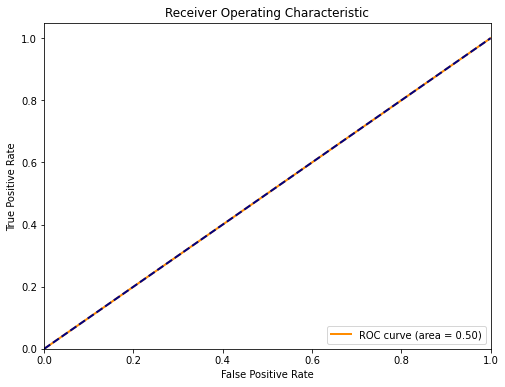

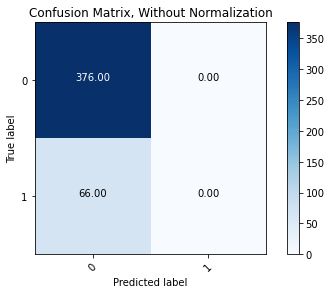

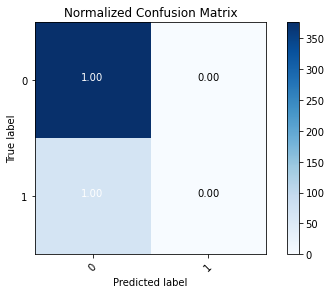

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       376
           1       0.00      0.00      0.00        66

    accuracy                           0.85       442
   macro avg       0.43      0.50      0.46       442
weighted avg       0.72      0.85      0.78       442



In [62]:
best_C=final_params['C']
best_auc_penalty_index=int(round(final_params['penalty']))
best_auc_penalty = penalty_options[best_auc_penalty_index]
best_auc_solver_index = int(round(final_params['solver']))# 반올림 후 인덱스 변환
best_auc_solver = solver_options[best_auc_solver_index]
best_max_iter=int(round(final_params['max_iter']))
best_tol=10 ** -final_params['tol']

model_f1 = LogisticRegression(
    C=best_C,
    penalty='l1',
    solver=best_auc_solver,
    max_iter=best_max_iter,
    tol=best_tol,
    random_state=42
)

train = X_train1[(X_train1['group'].isin([0,hyper_param['target'].idxmax()]))]
y = y_train1[train.index]

categorical_cols = ['Education', 'Marital_Status']
numeric_cols = [col for col in train.columns if col not in ['Education', 'Marital_Status', 'Response', 'group', 'Age_group','MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']]

# standard scaler
train_data_std = std_scale.fit_transform(train[numeric_cols])

train_data_enc = oh_encod.fit_transform(train[categorical_cols])

# process dataset 
processed_data = np.hstack((train_data_std, train_data_enc))

model_f1.fit(processed_data, y)
y_auc_pred = model_f1.predict(test_processed_data)
y_pred_proba = model_f1.predict_proba(test_processed_data)[:, 1]


f1 = f1_score(y_test, y_auc_pred)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"F1-Score on Test Data: {f1}")
print(f"AUC on Test Data: {auc}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

cm = confusion_matrix(y_test, model_f1.predict(test_processed_data))

def plot_conf_matrix(cm, classes,
                      normalize=False,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = ['0', '1']

# 시각화 실행
plot_conf_matrix(cm, classes=class_names,
                 title='Confusion Matrix, Without Normalization')

# 정규화된 혼동 행렬 시각화도 가능
plt.figure()
plot_conf_matrix(cm, classes=class_names, normalize=True,
                 title='Normalized Confusion Matrix')

plt.show()

from sklearn.metrics import classification_report

target_names = ['0', '1']
print(classification_report(y_test, y_auc_pred, 
                            target_names=target_names))

